In [3]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

## **Set up Environment**


In [4]:
# Download flower image file (jpg) dataset
import aimodelshare as ai
ai.download_data("public.ecr.aws/y2e2a1d6/flower-competition-data-repository:latest")


Data downloaded successfully.


In [5]:
# Extract filepaths to use to import and preprocess image files...
base_path = 'flower-competition-data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:4]) # Examples of file names...

## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [6]:
# Here is a pre-designed preprocessor, but you could also build your own to prepare the data differently

def preprocessor(data, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# tf.keras models require object to be an array rather than a list. (vstack converts above list to array object.)
import numpy as np
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [8]:
X.shape

(2936, 192, 192, 3)

In [9]:
# Create y training label data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 507)) #i.e.: 507 filenames in daisy folder
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels) 

# Need to one-hot encode for Keras. Let's use Pandas...
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2931,0,0,0,0,1
2932,0,0,0,0,1
2933,0,0,0,0,1
2934,0,0,0,0,1


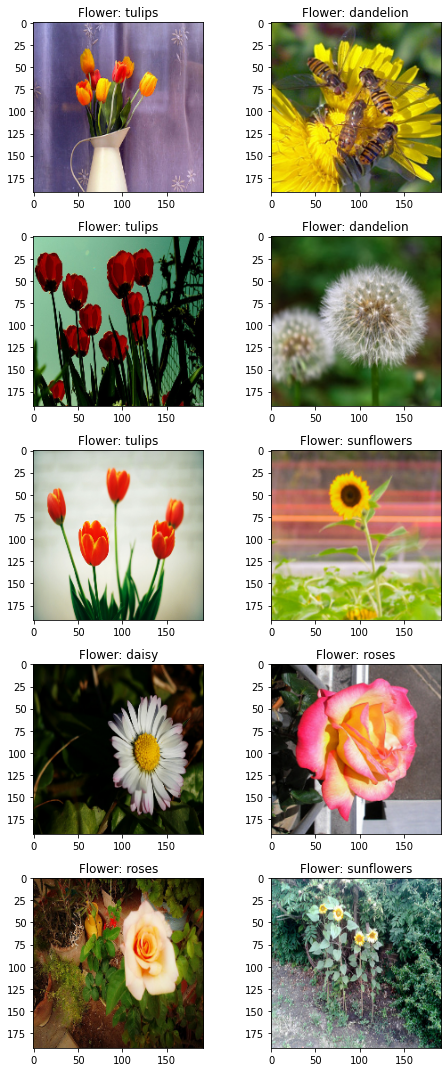

In [10]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()

In [11]:
# train_test_split resized images...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)
y_train 

,daisy,dandelion,roses,sunflowers,tulips
1046,0,1,0,0,0
28,1,0,0,0,0
2615,0,0,0,0,1
6,1,0,0,0,0
1807,0,0,0,1,0
...,...,...,...,...,...
61,1,0,0,0,0
429,1,0,0,0,0
1555,0,0,1,0,0
1077,0,1,0,0,0


## **Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [12]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [13]:
#  Now let's import and test the preprocessor function to see if it is working...

prep=ai.import_preprocessor("preprocessor.zip")

prep("flower-competition-data/train_images/daisy/10140303196_b88d3d6cec.jpg").shape

(1, 192, 192, 3)

## **Submit Models**

In [14]:
#Instantiate Competition 
mycompetition= ai.Competition("https://qr2jk18mxf.execute-api.us-east-1.amazonaws.com/prod/m")


In [15]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://qr2jk18mxf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [16]:
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        keras_model = Sequential()
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        keras_model.add(MaxPooling2D(pool_size=2))

        keras_model.add(Dropout(0.2))
        keras_model.add(Flatten())
        keras_model.add(Dense(16, activation='relu')) # One fully-connected layer of 16 neurons.
        keras_model.add(Dropout(0.2))

        keras_model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        keras_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = keras_model.fit(X_train, y_train,
                          epochs=1, verbose=1, validation_data=(X_test, y_test))

74/74 [==============================] - 129s 2s/step - loss: 2.4375 - accuracy: 0.3386 - val_loss: 1.7398 - val_accuracy: 0.3639


In [19]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [21]:
# Submit Model

#-- Generate predicted y values (Model 2)
prediction_column_index=keras_model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 4

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1527


Get Leaderboard

In [22]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,flatten_layers,dropout_layers,conv2d_layers,maxpooling2d_layers,softmax_act,relu_act,loss,optimizer,model_config,memory_size,username,version
0,39.12%,35.91%,55.46%,42.93%,keras,False,True,Sequential,5,11805061,4,1,nan,nan,nan,1,3,str,RMSprop,"{'name': 'sequential_1', 'laye...",2335848,hp2500test,3
1,36.39%,28.49%,36.32%,33.06%,keras,False,True,Sequential,8,4723237,2,1,2.000000,2.000000,1.000000,1,3,str,RMSprop,"{'name': 'sequential', 'layers...",2112944,hp2500test,4
2,27.55%,13.62%,17.16%,23.50%,keras,False,True,Sequential,8,4723237,2,1,2.000000,2.000000,1.000000,1,3,str,RMSprop,"{'name': 'sequential', 'layers...",2112944,AdvProjectsinML,1
3,21.60%,11.47%,27.64%,22.76%,keras,False,True,Sequential,8,4723237,2,1,2.000000,nan,1.000000,1,3,str,RMSprop,"{'name': 'sequential', 'layers...",2112944,hp2500test,2


Compare Models

In [24]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,3], verbose=1)
mycompetition.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_3_Layer,Model_3_Shape,Model_3_Params
0,Conv2D,"[None, 192, 192, 32]",416,Dense,"[None, 192, 192, 64]",256.000000
1,Conv2D,"[None, 192, 192, 32]",4128,Dense,"[None, 192, 192, 64]",4160.000000
2,MaxPooling2D,"[None, 96, 96, 32]",0,Dense,"[None, 192, 192, 64]",4160.000000
3,Dropout,"[None, 96, 96, 32]",0,Flatten,"[None, 2359296]",0.000000
4,Flatten,"[None, 294912]",0,Dense,"[None, 5]",11796485.000000
5,Dense,"[None, 16]",4718608,None,None,nan
6,Dropout,"[None, 16]",0,None,None,nan
7,Dense,"[None, 5]",85,None,None,nan


#### Check structure of y test data 
(This helps users understand how to submit predicted values to leaderboard)

In [25]:
mycompetition.inspect_y_test()

{'class_balance': {'daisy': 101,
  'dandelion': 144,
  'roses': 103,
  'sunflowers': 112,
  'tulips': 128},
 'class_labels': ['tulips', 'dandelion', 'roses', 'daisy', 'sunflowers'],
 'label_dtypes': {"<class 'str'>": 588},
 'y_length': 588,
 'ytest_example': ['roses', 'roses', 'roses', 'dandelion', 'roses']}